### Task :- Building a custom Alexnet and training with custom dataset
* Data :- Minimum 3 class having more than 250 images 

In [1]:
# Using this location as a root Directory
import os
ROOT = "/content/drive/MyDrive/Colab Notebooks/Deep learning"
os.chdir(ROOT)

In [2]:
!mkdir -p ~/.kaggle
!cp "kaggle.json" ~/.kaggle/

In [3]:
!kaggle datasets download -d drgfreeman/rockpaperscissors

rockpaperscissors.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('rockpaperscissors.zip', 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [5]:
# Importig the libraries
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt

In [61]:
WIDE = 300
HIGH = 200
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/rps-cv-images",
    shuffle=True,
    image_size=(WIDE, HIGH),
    batch_size=BATCH_SIZE
)  

Found 2188 files belonging to 3 classes.


In [8]:
os.listdir("/content/dataset/rps-cv-images")

['rock', 'README_rpc-cv-images.txt', 'paper', 'scissors']

In [9]:
cd "/content/dataset/rps-cv-images"

/content/dataset/rps-cv-images


In [10]:
rm -rf ".ipynb_checkpoints"

In [13]:
rm -rf "README_rpc-cv-images.txt"

In [14]:
os.listdir("/content/dataset/rps-cv-images")

['rock', 'paper', 'scissors']

In [15]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/rps-cv-images",
    shuffle=True,
    image_size=(WIDE, HIGH),
    batch_size=BATCH_SIZE
)

Found 2188 files belonging to 3 classes.


In [16]:
class_names = dataset.class_names

In [17]:
class_names

['paper', 'rock', 'scissors']

In [18]:
len(dataset)

69

In [19]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 300, 200, 3)
[0 0 1 2 1 2 2 2 2 0 1 1 0 2 0 2 2 2 0 1 2 0 2 1 1 1 0 1 2 1 2 1]


In [20]:
# first image array 
for image_batch, label_batch in dataset.take(1):
    # print(image_batch[0].numpy())
    print(image_batch[0].shape)

(300, 200, 3)


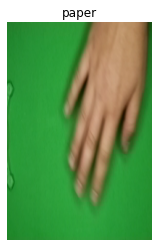

In [21]:
# Plotting the image 
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

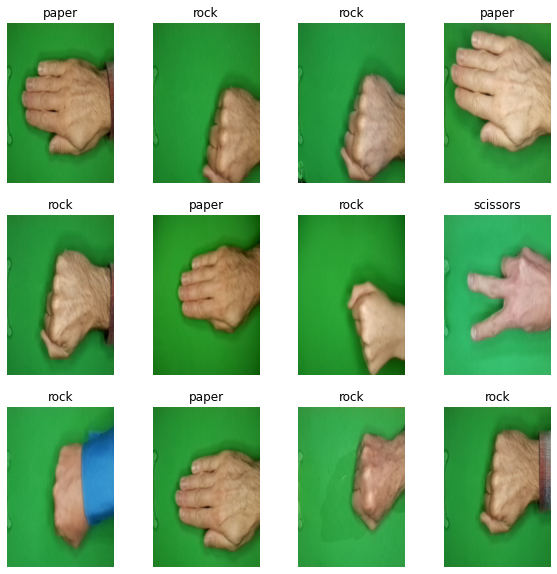

In [22]:
# Plotting the image 
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [23]:
from tensorflow.python import train
train_size = 0.8
len(dataset) * train_size

55.2

In [24]:
train_ds = dataset.take(54)
len(train_ds)

54

In [25]:
# Skiping the first 54 dataset
test_ds = dataset.skip(54)
len(test_ds)

15

In [26]:
val_size = 0.1
len(dataset) * val_size

6.9

In [27]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [28]:
test_ds = test_ds.skip(6)
len(test_ds)

9

In [29]:

def spliting_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, 
                        shuffle=True, shuffle_size=10000):
    try:
        ds_size = len(ds)

        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=100)

        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)

        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)

        return train_ds, val_ds, test_ds
    except Exception as e:
        print(e)

In [30]:
train_ds, val_ds, test_ds = spliting_dataset_tf(dataset)

In [31]:
len(train_ds), len(val_ds), len(test_ds)

(55, 6, 8)

In [32]:
# Prefetching and cacheing
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(WIDE, HIGH),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [37]:
# data Augumentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [38]:
input_shape = (BATCH_SIZE, WIDE, HIGH, CHANNELS)
n_classes = 3

### Creating a custom architecture with some changes like using Relu instead of Hyperbolic tangent and using stried (1, 1) every where. Using batch normalization insted of local response normalization.Using less dense units

In [39]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(96, kernel_size = (11, 11), activation='relu', input_shape=input_shape, strides=(1, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(256,  kernel_size = (11, 11), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(384,  kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(384, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 300, 200, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 290, 190, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (32, 145, 95, 96)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (32, 145, 95, 96)        384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (32, 135, 85, 256)        2973952   
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 67, 42, 256)       

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [43]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
55/55 [==============================] - 54s 985ms/step - loss: 0.1514 - accuracy: 0.9563 - val_loss: 1.0233 - val_accuracy: 0.7344
Epoch 2/10
55/55 [==============================] - 51s 928ms/step - loss: 0.0998 - accuracy: 0.9672 - val_loss: 1.3429 - val_accuracy: 0.7760
Epoch 3/10
55/55 [==============================] - 53s 955ms/step - loss: 0.1184 - accuracy: 0.9661 - val_loss: 0.4138 - val_accuracy: 0.9115
Epoch 4/10
55/55 [==============================] - 52s 940ms/step - loss: 0.0759 - accuracy: 0.9753 - val_loss: 0.8559 - val_accuracy: 0.8281
Epoch 5/10
55/55 [==============================] - 52s 944ms/step - loss: 0.0586 - accuracy: 0.9851 - val_loss: 0.0414 - val_accuracy: 0.9896
Epoch 6/10
55/55 [==============================] - 53s 957ms/step - loss: 0.0439 - accuracy: 0.9856 - val_loss: 0.0454 - val_accuracy: 0.9896
Epoch 7/10
55/55 [==============================] - 54s 981ms/step - loss: 0.0383 - accuracy: 0.9879 - val_loss: 0.0108 - val_accuracy: 0.9948

In [44]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 116ms/step - loss: 0.0063 - accuracy: 0.9961


In [45]:
scores

[0.006285069976001978, 0.99609375]

In [46]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 55}

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [48]:
type(history.history['loss'])

list

In [49]:
len(history.history['loss'])

10

In [50]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.15142899751663208,
 0.09983532130718231,
 0.11838474124670029,
 0.0758974552154541,
 0.058584511280059814]

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [59]:
range(EPOCHS)

range(0, 15)

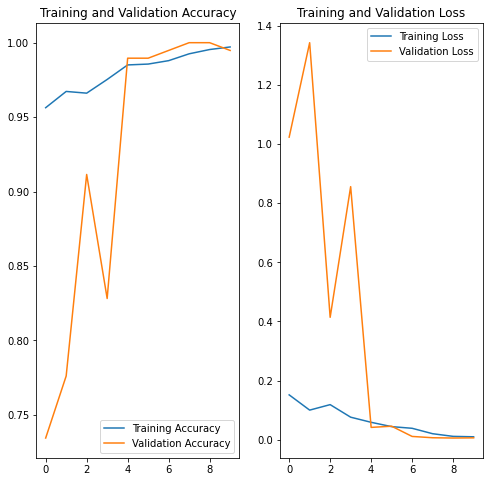

In [64]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: scissors
1/1 [==============================] - 0s 330ms/step
predicted label: scissors


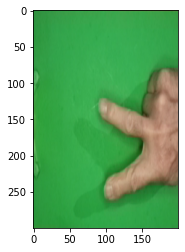

In [62]:

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [65]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


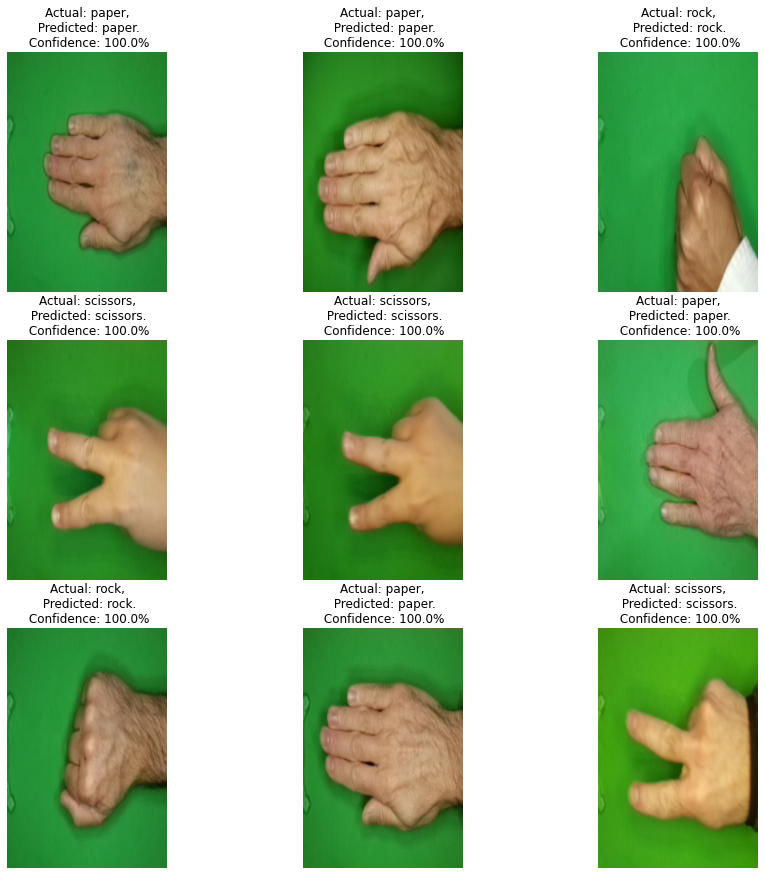

In [66]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")